<a href="https://colab.research.google.com/github/devparikh0506/DATA-602/blob/main/week_11/Homework_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import keras


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


NOTE: For each of these problems, use only TensorFlow libaries for numerical manipulation.  Credit will not be given for solutions that use Numpy.

# Problem 1 - Tensors

Using only TensorFlow capabilities (that is, without importing any numpy or sklearn classes), write a function `make_blobs` that returns tensors X and y. The function signature should be:

    def make_blobs(n_samples, n_clusters, n_features=2, cluster_std=1):

where
* `n_samples` represents the number of samples to generate (positive integer)
* `n_clusters` represents the number of clusters to generate (positive integer)
* `n_features` represents the number of features to generate (positive integer)
* `cluster_std` represents the standard deviation of the clusters

Each cluster center should be generated randomly using a uniform distribution in the range $(-10, 10)$.  The function should return `(X, y)`, where `X` represents the generated samples and `y` represents the cluster membership of each sample.

Using matplotlib, show visually that the function generates clusters of Gaussian blobs, similar to the `make_blobs` function in scikit-learn.

Hints:

* To generate a random integer $x : a \le x < b$, call `tf.random.uniform(minval=a, maxval=b, dtype='int32')`.
* You may use a loop, but a vectorized implementation without loops is possible and more efficient.  If you want to attempt this problem using a vectorized implementation, you may find the function [`tf.gather`](https://www.tensorflow.org/api_docs/python/tf/gather) to be useful.

In [3]:
def make_blobs(n_samples, n_clusters, n_features=2, cluster_std=1):
    centers = tf.random.uniform(
        shape=(n_clusters, n_features), minval=-10, maxval=10, dtype=tf.float32
    )

    labels = tf.random.uniform(
        shape=(n_samples,), minval=0, maxval=n_clusters, dtype=tf.int32
    )
    centers_per_sample = tf.gather(centers, labels)

    samples = centers_per_sample + tf.random.normal(
        shape=(n_samples, n_features), mean=0.0, stddev=cluster_std
    )

    return samples, labels

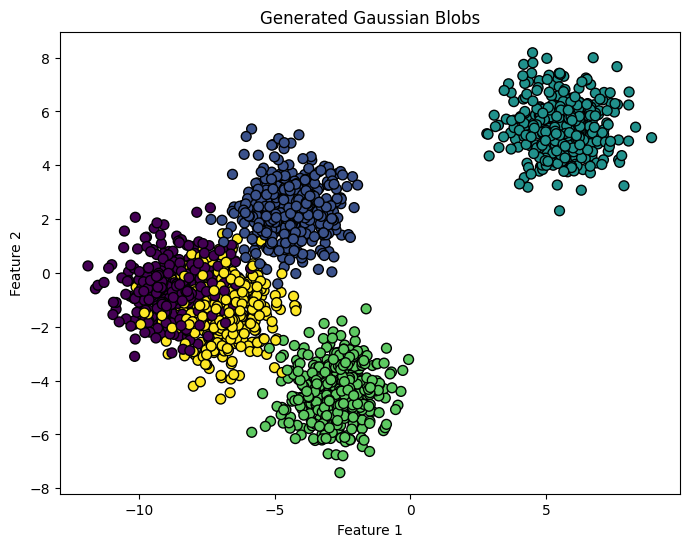

In [4]:
X, y = make_blobs(n_samples=2000, n_clusters=5, n_features=2, cluster_std=1)

X_np = X.numpy()
y_np = y.numpy()

plt.figure(figsize=(8, 6))
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title("Generated Gaussian Blobs")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Problem 2  - Gradient descent

Given a loss function $J(\mathbf{w}) = (w_0-2)^2 + (w_1+3)^2 + (w_2 + 4)^4$,
an initial value $\mathbf{w} = [0, 0, 0]$, and a learning rate $\eta = 0.05$,
use gradient descent to find the value of $\mathbf{w}$ that approximately minimizes $J(\mathbf{w})$.  Use autodifferentiation (GradientTape) to obtain $\nabla J$. Terminate computation when $\lVert{\nabla J(\mathbf{w})}\rVert < 0.001$.

In [12]:

w = tf.Variable([0.0, 0.0, 0.0])
learning_rate = 0.05
tolerance = 0.001
max_iterations = 1000
max_grad_norm = 1.0  # For gradient clipping

def loss_function(w):
    return (w[0] - 2)**2 + (w[1] + 3)**2 + (w[2] + 4)**4

iteration = 0
while iteration < max_iterations:
    iteration += 1

    # Printing progress every 100 iterations
    if iteration % 100 == 0:
        print(f"Iteration {iteration}: w = {w.numpy()}, loss = {loss_function(w).numpy()}")

    # Using GradientTape to compute gradients
    with tf.GradientTape() as tape:
        loss = loss_function(w)

    gradients = tape.gradient(loss, w)
    gradients = tf.clip_by_norm(gradients, max_grad_norm)
    grad_norm = tf.norm(gradients)

    if grad_norm < tolerance:
        print(f"Converged after {iteration} iterations!")
        break

    w.assign_sub(learning_rate * gradients)

    if tf.math.is_nan(loss):
        print("NaN detected, stopping optimization")
        break

print("\nFinal results:")
print(f"w = {w.numpy()}")
print(f"Final loss = {loss_function(w).numpy():.6f}")
print(f"Final gradient norm = {grad_norm.numpy():.6f}")

if iteration == max_iterations:
    print("\nWarning: Maximum iterations reached without convergence")

Iteration 100: w = [ 1.3280771 -1.9921156 -3.5297523], loss = 1.5162110328674316
Iteration 200: w = [ 1.9999663 -2.9999492 -3.847118 ], loss = 0.0005462978733703494
Iteration 300: w = [ 1.9999995 -2.999999  -3.8902245], loss = 0.00014521864068228751
Iteration 400: w = [ 1.9999995 -2.999999  -3.9098706], loss = 6.59880752209574e-05
Iteration 500: w = [ 1.9999995 -2.999999  -3.921719 ], loss = 3.7551199056906626e-05
Iteration 600: w = [ 1.9999995 -2.999999  -3.9298563], loss = 2.4207765818573534e-05
Iteration 700: w = [ 1.9999995 -2.999999  -3.9358892], loss = 1.6893654901650734e-05
Converged after 722 iterations!

Final results:
w = [ 1.9999995 -2.999999  -3.9370198]
Final loss = 0.000016
Final gradient norm = 0.000999


# Problem 3 - Neural network training

We return to the MNIST dataset.  The template provides code to load a neural network model that has been built and compiled but not yet trained.  The code also [loads](https://keras.io/api/datasets/mnist/) the MNIST dataset using the Keras built-in dataset.

In [13]:
import tensorflow as tf
import keras
from keras.datasets import mnist

In [24]:
# Important - These variables are not scaled and must be normalized from [0, 256] to [0, 1]

((X_train, y_train), (X_test, y_test)) = mnist.load_data(
    path='mnist.npz'
)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Load the model from Google Drive.  The warning can be safely disregarded; it occurs because the model
# has not been fit.
model = keras.models.load_model('/content/gdrive/Shareddrives/DS602-F22/Data/hw11-model.keras')


a. Describe the neural network.  How many hidden layers does it include, and how many neurons are in each hidden layer?  What is the total number of parameters that the model needs train?

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 335,114 (1.28 MB)

 Trainable params: 335,114 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

- The network includes 3 hidden layers
- All 3 hidden layers have 256 neurons each
- Total trainable parameters: 335,114 parameters

b. The first hidden Dense layer requires training of 200,960 weights (including bias terms).  Given the architecture of this network, why do we have this number of weights?

To understand the 200,960 weights in the first hidden Dense layer, we can break it down as follows:
- **Input Layer:** The input is flattened to 784 neurons (from 28x28 pixel images).
- **First Hidden Dense Layer:** This layer has 256 neurons.


**Calculation of Weights**

- Weights:
  Each of the 256 neurons in the hidden layer is connected to all 784 input neurons:
  - Number of weights = 784 x 256 = 200,704

- Bias Terms:
  Each neuron has one bias term:
  - Number of bias terms = 256


**Total Parameters** = Weights + Biases = 200,704+256 = 200,960

Thus, the first hidden Dense layer has 200,960 parameters due to the full connectivity between the input and hidden layers.

c. Train the model using the MNIST training data by calling `model.fit`.  Set the `validation_split` parameter to 0.1 to set aside 10% of the observations for validation.  Train until 20 epochs are completed or until validation accuracy does not improve for 5 consecutive epochs, whichever occurs first.  Save the return value of `model.fit` to a variable since it will be needed for part (d).

In [26]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1) # to stope training if validation accuracy does not improve for 5 consecutive epochs.
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1) # to save the best model based on validation accuracy.

model_history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_split=0.1,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2602 - loss: 4.1611
Epoch 1: val_accuracy improved from -inf to 0.31300, saving model to best_model.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.2602 - loss: 4.1605 - val_accuracy: 0.3130 - val_loss: 2.1775
Epoch 2/20
1686/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2846 - loss: 2.6968
Epoch 2: val_accuracy improved from 0.31300 to 0.35483, saving model to best_model.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.2846 - loss: 2.6973 - val_accuracy: 0.3548 - val_loss: 2.5078
Epoch 3/20
1687/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3205 - loss: 3.5456
Epoch 3: val_accuracy did not improve from 0.35483
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3205 - loss: 3.5454 - val_accuracy: 0.2802 - val_loss: 3.5381
Epoch 4/20
1685/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2601 - loss: 3.3333
Epoch 4: val_accuracy did not improve from 0.35483
1688/1688 ━━

d. Plot the training history (return value of `model.fit`), showing (1) the training/validation loss and (2) the training/validation accuracy.  Would the model benefit from additional training epochs?  Would it benefit from regularization?

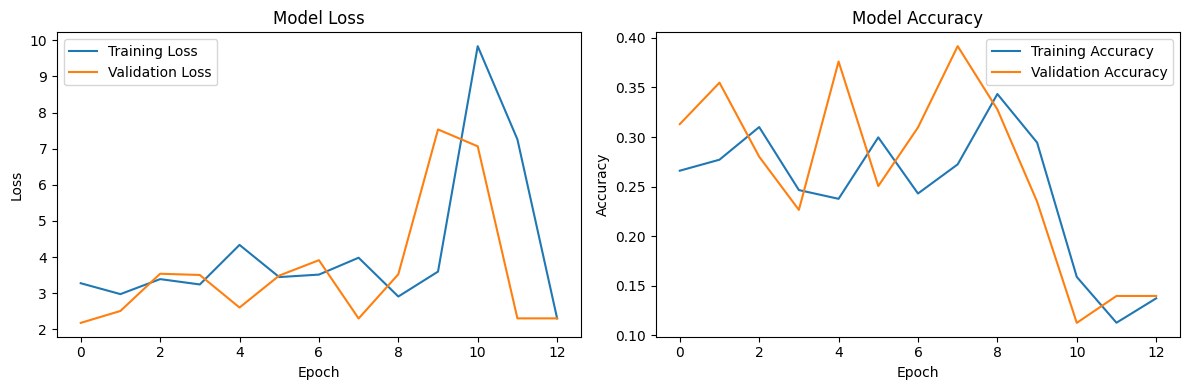

In [29]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

From above results:

- The model is unlikely to benefit from additional training epochs. The fluctuations in both training and validation loss indicate that it is not converging steadily. Simply adding more epochs may not help the model learn better and could lead to overfitting. Additional training epochs would only be beneficial if the model showed steady improvement over time, which is not evident here.

- Yes, the model would benefit from regularization. The fluctuations and potential overfitting suggest that techniques like dropout and L2 regularization could help. Dropout reduces reliance on specific neurons, making the model more robust, while L2 regularization discourages large weights, which can improve generalization. Additionally, early stopping could be helpful to prevent overfitting by halting training when validation performance stops improving.

e. Evaluate the fit model against the test data.  Is test accuracy comparable to the validation accuracy?

In [40]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Print the test accuracy and compare it with training accuracy if validation accuracy is unavailable
print(f"Test Accuracy: {test_accuracy}")
print(f"Validation Accuracy: {model_history.history['val_accuracy'][-1]}")

Test Accuracy: 0.13740000128746033
Validation Accuracy: 0.13966666162014008


The test accuracy is very close to the validation accuracy (0.1374 vs. 0.1397), with only a minor difference. This similarity suggests that the model's performance on the test data is comparable to its performance on the validation data, indicating that the model generalizes reasonably well to new, unseen data.

The small difference is expected, as slight variations between test and validation performance are common due to different subsets of data.